# Data preprocessing

**Data loading:**

---



In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import numpy as np
from tqdm.notebook import tqdm

yield_raw_data = pd.read_csv('IL_yield.csv')
era5_raw_data = pd.read_csv('ERA5.csv')
evi_stack_data = pd.read_csv('EVI_stacked.csv')




**ERA5 preprocessing:**

---



Conversión de filas a columnas por campos 'county','long','lat','year'.
Conversión de temperaturas a Fº a Cº.

Redondeo de latitud y longitud para casar con el dataset de EVI y agrupación por media simple de grupos (year,county,long,lat)


In [2]:
era5_data = era5_raw_data.copy()
era5_data['time'] = pd.to_datetime(era5_data['time'])
era5_data['year'] = era5_data['time'].dt.year
era5_data['day'] = era5_data['time'].dt.dayofyear
era5_data['t2m'] = era5_data['t2m'] - 273.15 #to Celsius (Cº)
era5_data['leapyear'] = era5_data['time'].dt.is_leap_year
era5_data['day'] = era5_data.apply(lambda x : x['day']-1 if (x['leapyear'] and x['day']> 59) else x['day'], axis=1)
era5_data.pop('leapyear')
era5_stack_data = era5_data.pivot_table('t2m',['county','long','lat','year'],'day').rename_axis(None, axis=1)
era5_stack_data.reset_index(inplace=True)
era5Days = [col for col in era5_stack_data.columns if isinstance(col, int)]#era5Dats: days where era5 data is available
era5_stack_data.columns = [f't2m_{col}' if isinstance(col, int) else col for col in era5_stack_data.columns]
era5_stack_data = era5_stack_data.groupby(by=['county','year']).mean().rename_axis(None, axis=1)
era5_stack_data.reset_index(inplace=True)
era5_stack_data.sort_values(by=['county','year'], inplace=True)
era5_stack_data.reset_index(inplace=True, drop=True)
era5_stack_data.drop(['long','lat'], axis=1,inplace=True)
era5_stack_data.head()

,county,year,t2m_1,t2m_15,t2m_28,t2m_32,t2m_46,t2m_59,t2m_60,t2m_74,t2m_87,t2m_91,t2m_105,t2m_118,t2m_121,t2m_135,t2m_148,t2m_152,t2m_166,t2m_179,t2m_182,t2m_196,t2m_209,t2m_213,t2m_227,t2m_240,t2m_244,t2m_258,t2m_271,t2m_274,t2m_288,t2m_301,t2m_305,t2m_319,t2m_332,t2m_335,t2m_349,t2m_362
0,ADAMS,1979,-7.243292,-20.811003,-5.111502,-14.565009,2.269037,2.778970,2.189081,0.970056,5.601236,5.304529,15.278528,9.357385,10.892252,19.571268,19.911218,22.234109,28.909601,25.233911,27.146936,30.993616,24.734521,25.138849,15.978555,24.400598,24.313104,16.480447,22.624368,22.309045,14.633310,15.243829,13.714502,6.977686,1.895380,-1.248740,0.182001,-1.831091
1,ADAMS,1980,0.442514,5.439310,-9.558646,-11.698477,1.098795,1.387445,-9.818640,7.599268,12.692606,10.652856,0.773920,16.793756,15.234277,18.318033,28.190454,23.644235,31.523157,33.282800,26.543451,35.221979,23.303278,29.654901,23.466211,30.726572,29.412485,18.751550,15.049203,22.210977,18.015298,2.960016,11.645090,3.432245,0.572748,10.248529,1.780222,-2.549734
2,ADAMS,1981,2.304742,-0.446616,2.731699,1.020853,3.162180,17.414346,4.587396,7.885416,18.440759,19.586862,12.339075,27.263605,17.274026,9.998087,23.935419,22.463434,29.402933,26.438348,27.133356,29.601587,24.068201,26.099390,31.203317,22.417673,24.913553,24.700830,19.754327,28.039575,14.794733,9.830118,15.353952,11.364954,0.784982,4.444574,-1.062674,-0.453146
3,ADAMS,1982,-4.502509,-16.152151,5.373926,-8.137946,6.799142,1.823969,3.251184,5.113443,2.751825,15.176431,17.549615,12.741907,18.461862,20.759622,22.829538,17.220712,25.398355,23.792596,23.546182,27.330988,27.775049,28.105966,24.648035,20.229562,25.403894,22.292444,16.920984,24.755655,15.132684,15.539529,20.059076,-2.021704,2.650735,12.150995,4.447092,9.378015
4,ADAMS,1983,-1.008353,-2.839926,-2.979208,-2.273154,8.402902,6.715158,11.671732,7.532373,2.340952,9.547998,2.546136,16.812875,18.947168,10.930460,22.372903,16.083170,21.989694,28.818063,31.842493,31.136438,32.147256,31.290826,28.406183,30.857828,27.671960,19.769922,23.253488,22.017877,15.521936,17.395227,14.746454,8.943506,8.148935,-3.102927,-5.065741,-5.173361


**EVI preprocessing:**

---


Create synthetic observation for DOY=365.

In [3]:

#create synthetic observation for DOY=365. Will be useful for interpolation later (simple y=mx+b)
evi_stack_data['evi_365'] = ((evi_stack_data['evi_353']-evi_stack_data['evi_337'])/(353-337))*(365-337)+evi_stack_data['evi_337']
#replace column names to use them as DOY observation 
# evi_stack_data.columns = evi_stack_data.columns.str.replace("evi_", "")
evi_stack_data.head()


,year,county,long,lat,evi_1,evi_17,evi_33,evi_49,evi_65,evi_81,evi_97,evi_113,evi_129,evi_145,evi_161,evi_177,evi_193,evi_209,evi_225,evi_241,evi_257,evi_273,evi_289,evi_305,evi_321,evi_337,evi_353,evi_365
0,2001,ADAMS,-91.525,40.075,-0.146923,0.156453,-0.072903,-0.063690,-0.078860,-0.292650,-0.027958,0.002118,0.078466,0.239539,0.097495,0.090312,-0.286143,-0.287875,0.127960,0.630331,0.057551,0.028800,0.224734,-0.037140,-0.054813,0.095283,0.132038,0.159604
1,2001,ADAMS,-91.525,40.125,-0.156214,-0.188116,-0.091597,-0.109840,-0.099103,0.021988,-0.062362,-0.032532,0.018832,-0.031793,0.041932,0.027115,0.207051,0.226016,0.078727,-0.084846,0.029688,0.003740,-0.170605,-0.061510,-0.064935,-0.092197,-0.100994,-0.107592
2,2001,ADAMS,-91.525,40.175,0.000551,0.082851,0.108108,0.104726,0.101105,0.126727,0.176437,0.215933,0.354114,0.130009,0.407055,0.389221,0.442552,0.455470,0.454312,0.411025,0.357470,0.320813,0.237779,0.165385,0.161586,0.142840,0.017134,-0.077145
3,2001,ADAMS,-91.525,40.225,-0.005583,0.084916,0.116382,0.115102,0.107363,0.130750,0.201068,0.238947,0.385306,0.140931,0.441663,0.451710,0.487719,0.436069,0.462088,0.436204,0.374752,0.330077,0.250325,0.180660,0.169659,0.148152,0.017000,-0.081363
4,2001,ADAMS,-91.475,39.975,-0.030379,0.079086,0.107433,0.092655,0.078413,0.107965,0.137886,0.144569,0.200328,0.208104,0.275289,0.336119,0.451185,0.544530,0.531395,0.461023,0.335277,0.239753,0.155304,0.102718,0.097096,0.079518,0.084052,0.087451


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys


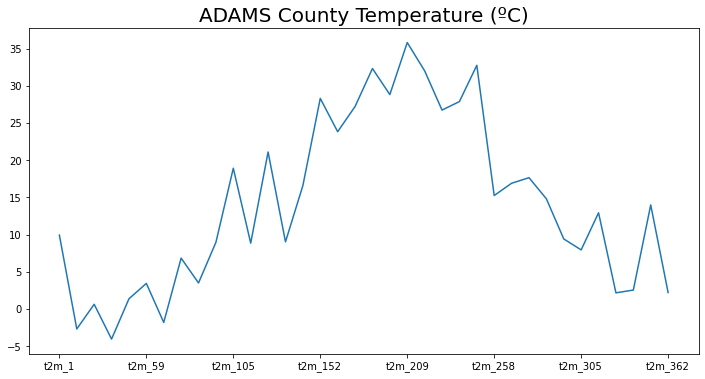

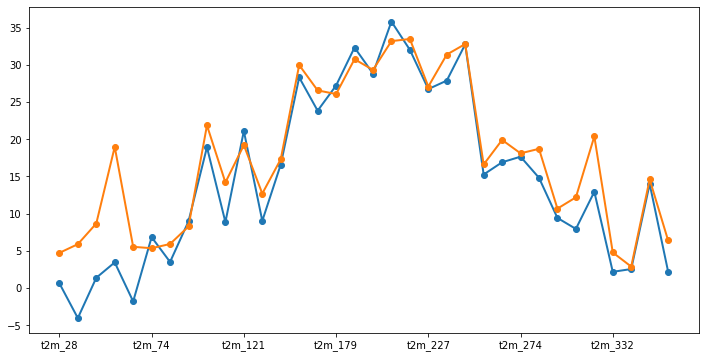

In [32]:

plt.rcParams["figure.figsize"] = (12,6)
#represent Temperature observations for ADAMS county in 2001  
era5_stack_data[(era5_stack_data['county'] == "ADAMS") & (era5_stack_data['year'] == 2011)].iloc[:,2:].transpose().plot(legend=None, linewidth=1.5)
plt.title('ADAMS County Temperature (ºC)', fontsize=20)
#represent ERA mean   
era5_stack_data[(evi_stack_data['county'] == "ADAMS") & (era5_stack_data['year'] == 2011)].groupby(by=['county','year']).median().iloc[:,2:].transpose().plot(legend=None,marker='o', linewidth=2)

plt.show()

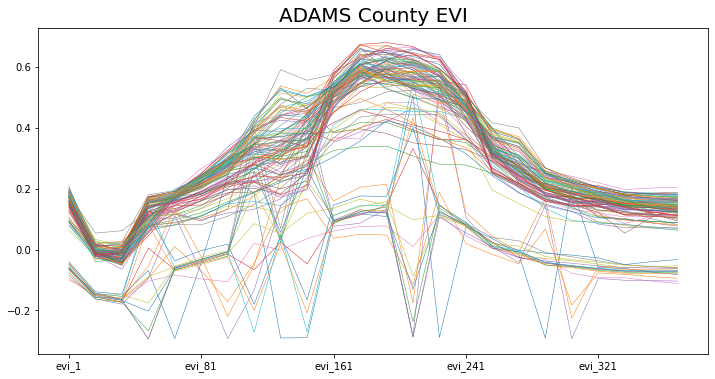

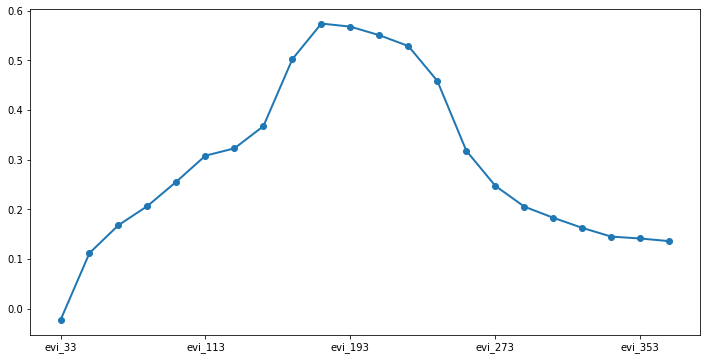

In [4]:

plt.rcParams["figure.figsize"] = (12,6)
#represent EVI observations for ADAMS county in 2001  
evi_stack_data[(evi_stack_data['county'] == "ADAMS") & (evi_stack_data['year'] == 2011)].iloc[:,4:].transpose().plot(legend=None, linewidth=0.5)
plt.title('ADAMS County EVI', fontsize=20)
#represent EVI mean   
evi_stack_data[(evi_stack_data['county'] == "ADAMS") & (evi_stack_data['year'] == 2011)].groupby(by=['county','year']).median().iloc[:,4:].transpose().plot(legend=None,marker='o', linewidth=2)

plt.show()

Testing interpolation.

Text(0.5, 0.98, 'Interpolated EVI (ADAMS / 2011)')

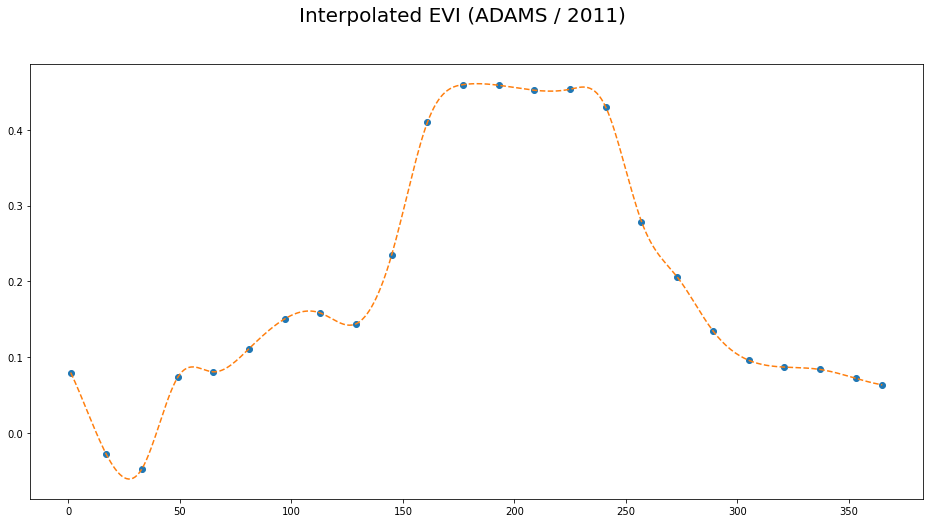

In [5]:
#Interpolate in order to obtain values for any DOY (will help us to match other observations)
from scipy.interpolate import interp1d

rowExample=9
sampleDf=evi_stack_data[(evi_stack_data['county'] == "ADAMS") & (evi_stack_data['year'] == 2011)].iloc[rowExample,4:]
sampleValues=sampleDf.values.astype(float)
sampleDates= [int(i.split('evi_')[1]) for i in evi_stack_data.columns[4:]]
xnew = np.linspace(1, 365, num=365, endpoint=True).round()

plt.rcParams["figure.figsize"] = (16,8)
evi_interp = interp1d(sampleDates, sampleValues,kind='cubic')
fig = plt.figure()
plt.plot(sampleDates, sampleValues, 'o', xnew, evi_interp(xnew), '--')
fig.suptitle('Interpolated EVI (ADAMS / 2011)', fontsize=20)


In [6]:
#Test to get EVI for any DOY
print(evi_interp(120))
print(evi_interp(3))
print(evi_interp(365))

0.1476428524753975
0.06668440235628242
0.06323693181818182


In [7]:
nRows, nColumns = evi_stack_data.shape
evi_stack_interpolate_data = evi_stack_data.copy()

evi_stack_data_doys = [float(i.split('evi_')[1]) for i in evi_stack_data.columns[4:]]
print(evi_stack_data_doys)


for i, row in tqdm(evi_stack_interpolate_data.iterrows(), desc='Interpolating', total=nRows):
  sampleDf=row.iloc[4:nColumns]
  sampleValues=sampleDf.values.astype(float)
  evi_interp = interp1d(evi_stack_data_doys, sampleValues,kind='cubic')
  for v in era5Days:#days where era5 data is available
    evi_stack_interpolate_data.at[i,v]=evi_interp(v)




evi_stack_interpolate_data.drop(evi_stack_interpolate_data.columns[4:28], axis = 1, inplace = True)

evi_stack_interpolate_data_doys = [float(i) for i in evi_stack_interpolate_data.columns[4:]]

evi_stack_interpolate_data.columns = [f'evi_{col}' if isinstance(col, int) else col for col in evi_stack_interpolate_data.columns]

print(evi_stack_interpolate_data_doys)




[1.0, 17.0, 33.0, 49.0, 65.0, 81.0, 97.0, 113.0, 129.0, 145.0, 161.0, 177.0, 193.0, 209.0, 225.0, 241.0, 257.0, 273.0, 289.0, 305.0, 321.0, 337.0, 353.0, 365.0]


Interpolating:   0%|          | 0/95418 [00:00<?, ?it/s]

[1.0, 15.0, 28.0, 32.0, 46.0, 59.0, 60.0, 74.0, 87.0, 91.0, 105.0, 118.0, 121.0, 135.0, 148.0, 152.0, 166.0, 179.0, 182.0, 196.0, 209.0, 213.0, 227.0, 240.0, 244.0, 258.0, 271.0, 274.0, 288.0, 301.0, 305.0, 319.0, 332.0, 335.0, 349.0, 362.0]


In [8]:
evi_stack_data.to_csv('EVI_stacked_interp')
evi_stack_interpolate_data.head(10)




,year,county,long,lat,evi_1,evi_15,evi_28,evi_32,evi_46,evi_59,evi_60,evi_74,evi_87,evi_91,evi_105,evi_118,evi_121,evi_135,evi_148,evi_152,evi_166,evi_179,evi_182,evi_196,evi_209,evi_213,evi_227,evi_240,evi_244,evi_258,evi_271,evi_274,evi_288,evi_301,evi_305,evi_319,evi_332,evi_335,evi_349,evi_362
0,2001,ADAMS,-91.525,40.075,-0.146923,0.168785,-0.006231,-0.062446,-0.079285,-0.037210,-0.039988,-0.232059,-0.223085,-0.140658,0.017046,0.003988,0.014062,0.158618,0.225761,0.185324,0.100958,0.058781,-0.007450,-0.328155,-0.287875,-0.223051,0.213761,0.632251,0.579957,0.029153,-0.001919,0.045682,0.226707,0.033028,-0.037140,-0.069577,0.053531,0.080468,0.130261,0.146198
1,2001,ADAMS,-91.525,40.125,-0.156214,-0.198122,-0.115016,-0.094961,-0.101376,-0.121790,-0.120102,-0.018379,0.003727,-0.024404,-0.066197,-0.006566,0.006754,-0.002518,-0.023200,-0.001244,0.035808,0.040642,0.070935,0.229556,0.226016,0.201440,0.051790,-0.083097,-0.079012,0.036183,0.022712,-0.007475,-0.167581,-0.093768,-0.061510,-0.059251,-0.086680,-0.090239,-0.099405,-0.105407
2,2001,ADAMS,-91.525,40.175,0.000551,0.076265,0.104627,0.107663,0.106235,0.100688,0.100546,0.109817,0.148659,0.163028,0.178499,0.278323,0.318046,0.265959,0.151935,0.223493,0.434996,0.387039,0.391941,0.451166,0.455470,0.455941,0.451490,0.414647,0.399977,0.355130,0.327285,0.317106,0.243627,0.177460,0.165385,0.160222,0.158848,0.150880,0.054094,-0.058439
3,2001,ADAMS,-91.525,40.225,-0.005583,0.077371,0.111302,0.115647,0.116627,0.109353,0.108887,0.112049,0.160303,0.180888,0.202935,0.304561,0.346900,0.289758,0.163484,0.239554,0.480523,0.450892,0.456386,0.483724,0.436069,0.435707,0.463758,0.439763,0.424779,0.371700,0.336944,0.326266,0.255805,0.193057,0.180660,0.169120,0.164861,0.156525,0.055576,-0.061859
4,2001,ADAMS,-91.475,39.975,-0.030379,0.070618,0.104993,0.107319,0.096962,0.079784,0.079063,0.091069,0.122714,0.130844,0.137563,0.160965,0.173309,0.204437,0.216331,0.232618,0.293678,0.347374,0.366781,0.474148,0.544530,0.550324,0.525400,0.467473,0.439650,0.328052,0.250542,0.234320,0.160082,0.110557,0.102718,0.097915,0.084480,0.081122,0.081341,0.087987
5,2001,ADAMS,-91.475,40.025,0.011736,0.066505,0.086642,0.087793,0.079487,0.073272,0.073556,0.096303,0.131126,0.139103,0.143656,0.189249,0.212918,0.310939,0.346249,0.351176,0.350197,0.332244,0.327942,0.318739,0.343475,0.360986,0.471510,0.553644,0.523050,0.323757,0.293629,0.286638,0.194531,0.139302,0.127395,0.096624,0.148086,0.162947,0.183818,0.183159
6,2001,ADAMS,-91.475,40.075,-0.148270,-0.125706,-0.105793,-0.102789,-0.107023,-0.110780,-0.110240,-0.083676,-0.067701,-0.069669,-0.073469,-0.043556,-0.032290,-0.003412,0.005634,0.016292,0.043190,0.057896,0.068958,0.134971,0.158412,0.149910,0.101232,0.077769,0.065969,0.019793,0.001940,-0.007579,-0.074614,-0.083373,-0.081542,-0.090963,-0.089962,-0.088079,-0.080779,-0.074891
7,2001,ADAMS,-91.475,40.125,-0.019611,0.068327,0.098039,0.100502,0.096916,0.094053,0.094481,0.115695,0.134495,0.135887,0.138909,0.209454,0.233167,0.179635,0.126192,0.197469,0.439979,0.460798,0.465007,0.507345,0.554400,0.566021,0.565951,0.489629,0.458862,0.363257,0.313557,0.301007,0.222989,0.156537,0.144062,0.134609,0.129351,0.121781,0.037631,-0.059054
8,2001,ADAMS,-91.475,40.175,-0.047713,0.035533,0.065429,0.068454,0.067320,0.065478,0.065864,0.085052,0.111963,0.117943,0.121325,0.147714,0.157647,0.100024,0.074264,0.134264,0.357494,0.421793,0.432163,0.500654,0.580958,0.593743,0.569324,0.463327,0.423586,0.297998,0.228545,0.214777,0.149362,0.104743,0.097584,0.096075,0.092882,0.086542,0.016047,-0.064902
9,2001,ADAMS,-91.475,40.225,-0.048605,0.045299,0.075261,0.077213,0.071271,0.067686,0.068198,0.093065,0.112563,0.112783,0.109757,0.158756,0.175501,0.122853,0.086065,0.151376,0.400320,0.454444,0.454868,0.489305,0.570639,0.570954,0.495989,0.416825,0.394002,0.317040,0.246718,0.230529,0.159575,0.114004,0.106429,0.102066,0.097972,0.091463,0.018176,-0.066178


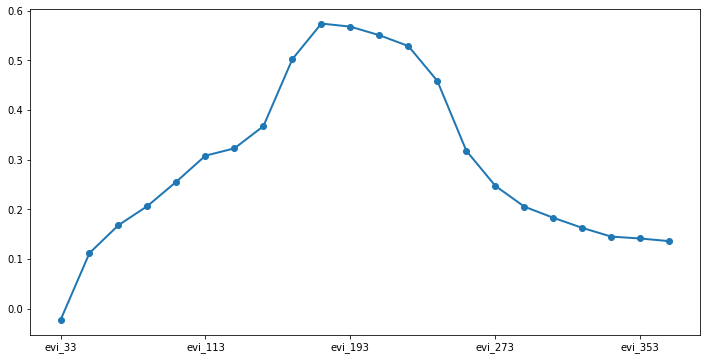

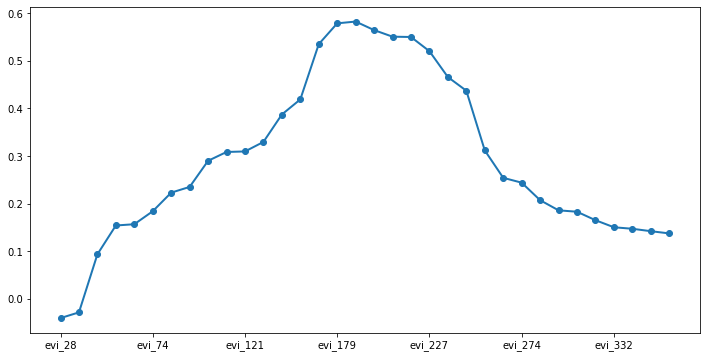

In [9]:
plt.rcParams["figure.figsize"] = (12,6)

#plt.plot(x1, y1, 'o', x2, y2, '--')

#represent EVI mean **interp** 
evi_stack_data[(evi_stack_data['county'] == "ADAMS") & (evi_stack_data['year'] == 2011)].groupby(by=['county','year']).median().iloc[:,4:28].transpose().plot(legend=None,marker='o', linewidth=2)
#represent EVI median **interp**   
evi_stack_interpolate_data[(evi_stack_interpolate_data['county'] == "ADAMS") & (evi_stack_interpolate_data['year'] == 2011)].groupby(by=['county','year']).median().iloc[:,4:].transpose().plot(legend=None,marker='o', linewidth=2)


plt.show()

Agrupación por media simple de grupos (year,county)

---



In [10]:
evi_stack_interpolate_data.sort_values(by=['county','year','long','lat'], inplace=True)
evi_stack_interpolate_data = evi_stack_interpolate_data.groupby(by=['county','year']).mean().rename_axis(None, axis=1)
evi_stack_interpolate_data.reset_index(inplace=True)
evi_stack_interpolate_data.drop(['long','lat'], axis=1,inplace=True)
evi_stack_interpolate_data.head()



,county,year,evi_1,evi_15,evi_28,evi_32,evi_46,evi_59,evi_60,evi_74,evi_87,evi_91,evi_105,evi_118,evi_121,evi_135,evi_148,evi_152,evi_166,evi_179,evi_182,evi_196,evi_209,evi_213,evi_227,evi_240,evi_244,evi_258,evi_271,evi_274,evi_288,evi_301,evi_305,evi_319,evi_332,evi_335,evi_349,evi_362
0,ADAMS,2001,-0.031036,0.080365,0.119704,0.123183,0.118161,0.111506,0.111546,0.126219,0.162237,0.175945,0.223687,0.296106,0.316861,0.348670,0.337680,0.355090,0.435932,0.484327,0.493566,0.533290,0.554475,0.551808,0.503656,0.419042,0.390140,0.306197,0.270480,0.262321,0.211996,0.173990,0.167336,0.160883,0.154451,0.151652,0.133635,0.115141
1,ADAMS,2002,0.117097,0.124487,0.119876,0.117955,0.114638,0.120248,0.121209,0.144489,0.171521,0.180621,0.232503,0.277378,0.283149,0.316770,0.356483,0.364865,0.397157,0.452941,0.469691,0.529949,0.535022,0.533997,0.517266,0.461347,0.435940,0.328828,0.236956,0.223094,0.195359,0.176619,0.167694,0.132797,0.129974,0.130816,0.117520,0.097976
2,ADAMS,2003,0.121478,0.011356,0.073473,0.092526,0.094674,0.085611,0.086294,0.118003,0.160007,0.172728,0.234591,0.294602,0.304500,0.333505,0.355580,0.365591,0.398611,0.452417,0.475795,0.584684,0.603676,0.589239,0.505113,0.436675,0.416524,0.338498,0.260288,0.246548,0.208413,0.180681,0.173535,0.152711,0.113268,0.101217,0.039386,-0.019764
3,ADAMS,2004,0.123930,0.147620,0.012384,-0.003672,0.106916,0.151562,0.150602,0.165326,0.214747,0.227572,0.250224,0.286239,0.301461,0.358505,0.382299,0.392396,0.467533,0.559218,0.571761,0.597609,0.599342,0.594593,0.527914,0.397334,0.363863,0.295861,0.263321,0.253424,0.197504,0.174428,0.167473,0.132564,0.140247,0.144105,0.136586,0.118964
4,ADAMS,2005,0.038249,0.108804,0.126521,0.127072,0.123500,0.118628,0.118376,0.120080,0.141365,0.153984,0.223008,0.286128,0.295831,0.328684,0.379755,0.405332,0.480196,0.513086,0.521338,0.534402,0.499190,0.492544,0.460954,0.375831,0.347055,0.271664,0.250106,0.246615,0.226196,0.215708,0.209727,0.158025,0.077051,0.062993,0.060886,0.083684


**Yield preprocessing:**

Eliminación de la tendencia de la Yield

---



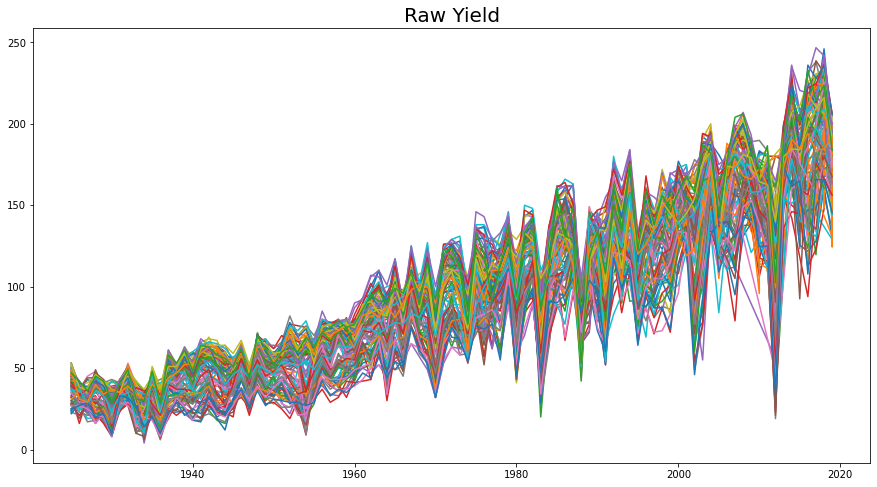

In [11]:
plt.figure(figsize=(15, 8))
for _, group in yield_raw_data.groupby(by=['county']):

  plt.plot(group['year'], group['yield'])

plt.title('Raw Yield', fontsize=20)

plt.show()




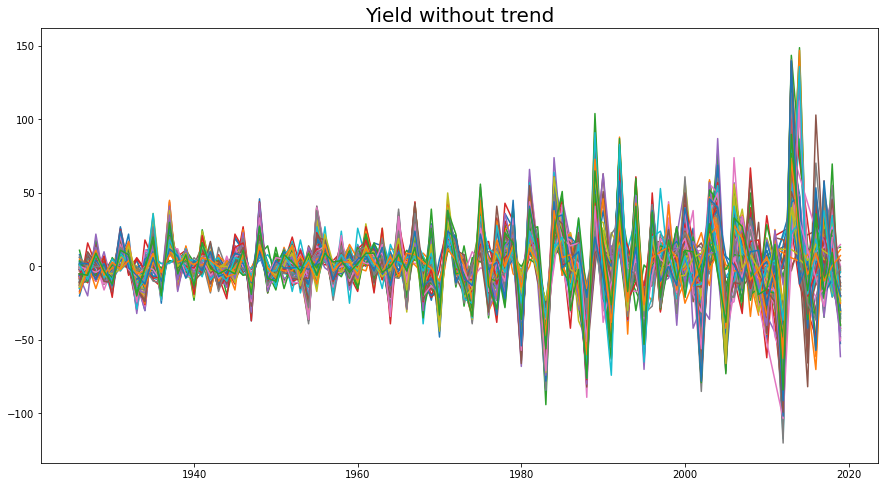

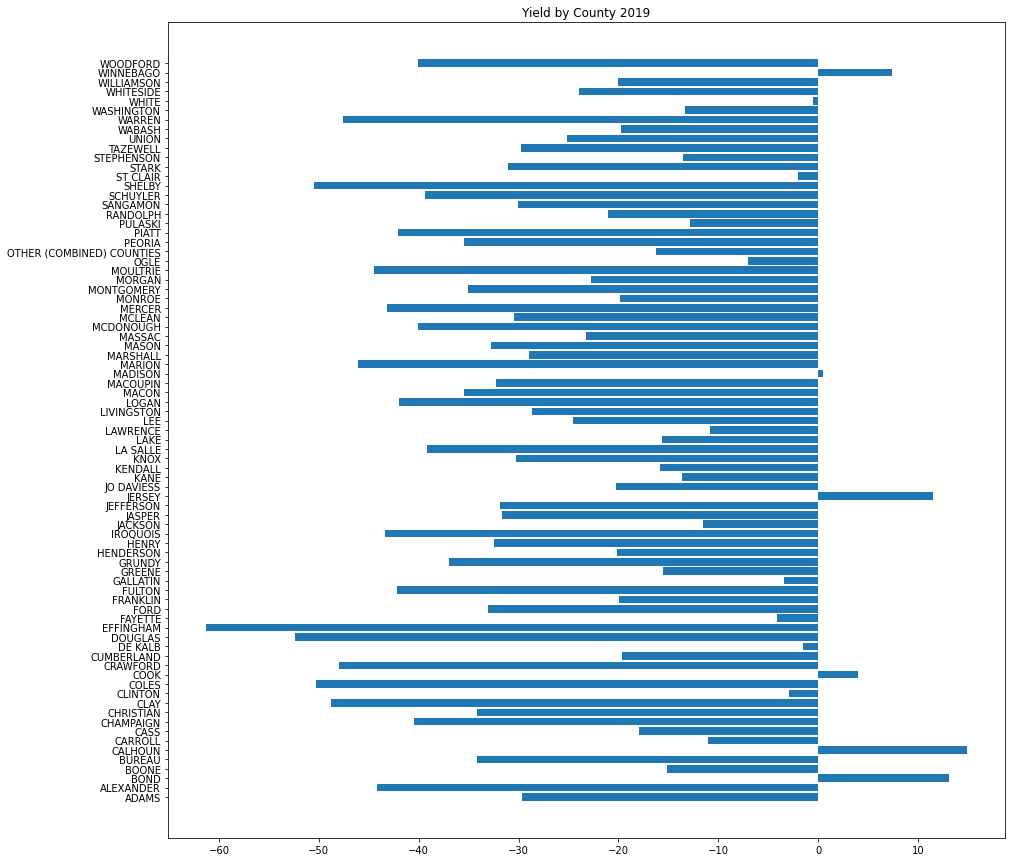

In [12]:
yield_custom_data = yield_raw_data.copy()


yield_custom_data = yield_custom_data.groupby(by=['county','year']).mean().rename_axis(None, axis=1)
yield_custom_data.reset_index(inplace=True)
yield_custom_data.reset_index(inplace=True, drop=True)


yield_custom_data['yield'] = yield_custom_data.sort_values(by=['county','year'], ascending=[True,True]).groupby(by=['county'])['yield'].diff()

fig1, ax1 = plt.subplots(figsize=(15,8))
ax1.title.set_text('Yield without trend')
ax1.title.set_fontsize(20)

for _, group in yield_custom_data.groupby(by=['county']):

  ax1.plot(group['year'], group['yield'])



fig2, ax2 = plt.subplots(figsize=(15,15))
ax2.title.set_text('Yield by County 2019')

ax2.barh(yield_custom_data[yield_custom_data.year == 2019]['county'],yield_custom_data[yield_custom_data.year == 2019]['yield'])

plt.show()


Creación del dataset definitivo mergeando los 3 dataset tratados.


---



In [13]:
df = pd.merge(evi_stack_interpolate_data, era5_stack_data,how='inner',on=['year','county'])
df = pd.merge(df, yield_custom_data, how='inner', on=['year','county'])


In [14]:
df[df.year == 2019].head(111)

,county,year,evi_1,evi_15,evi_28,evi_32,evi_46,evi_59,evi_60,evi_74,evi_87,evi_91,evi_105,evi_118,evi_121,evi_135,evi_148,evi_152,evi_166,evi_179,evi_182,evi_196,evi_209,evi_213,evi_227,evi_240,evi_244,evi_258,evi_271,evi_274,evi_288,evi_301,evi_305,evi_319,evi_332,evi_335,evi_349,evi_362,t2m_1,t2m_15,t2m_28,t2m_32,t2m_46,t2m_59,t2m_60,t2m_74,t2m_87,t2m_91,t2m_105,t2m_118,t2m_121,t2m_135,t2m_148,t2m_152,t2m_166,t2m_179,t2m_182,t2m_196,t2m_209,t2m_213,t2m_227,t2m_240,t2m_244,t2m_258,t2m_271,t2m_274,t2m_288,t2m_301,t2m_305,t2m_319,t2m_332,t2m_335,t2m_349,t2m_362,yield
17,ADAMS,2019,0.126653,-0.058563,0.063819,0.102965,0.130684,0.126141,0.126812,0.141748,0.167092,0.178561,0.234996,0.282660,0.289365,0.309048,0.327134,0.335272,0.374512,0.432028,0.448826,0.504627,0.514169,0.524476,0.546872,0.475654,0.443480,0.349892,0.323003,0.314066,0.244006,0.204793,0.198795,0.180434,0.149562,0.142715,0.128028,0.121292,3.397211,-1.317206,-6.626791,-9.961920,4.649484,-4.561255,-4.130927,5.424066,17.192148,4.495569,5.240549,12.223627,12.845667,20.000864,25.341409,25.876932,20.236292,29.450204,32.214288,29.900110,29.683359,25.230753,26.586389,24.927484,21.254495,25.482126,22.546823,28.241205,13.207666,12.455850,-1.214743,-1.499350,2.750604,9.985498,-2.860449,2.387216,-29.7
29,ALEXANDER,2019,0.093375,0.109266,0.113897,0.111775,0.091003,0.071469,0.070673,0.078900,0.115017,0.129817,0.187749,0.232476,0.238800,0.236925,0.231733,0.240918,0.261540,0.262664,0.270397,0.328442,0.376648,0.387257,0.400950,0.386742,0.383760,0.373584,0.330187,0.312654,0.223591,0.212446,0.219381,0.225059,0.145832,0.126729,0.106462,0.115519,12.100214,1.317102,3.292474,-0.237524,13.415308,7.695886,-1.231146,15.662103,14.551019,6.066583,6.925409,23.196619,24.798608,20.284082,29.501672,26.278558,23.384241,26.143762,31.469751,25.929742,28.537195,28.293115,30.888696,27.244867,27.895105,26.340479,28.661951,28.522607,15.344263,14.360681,1.204156,4.623987,7.639429,15.577417,4.545648,10.621179,-44.2
41,BOND,2019,0.175877,0.175006,0.166794,0.164205,0.161991,0.179150,0.180405,0.179060,0.225083,0.255644,0.336642,0.356213,0.356827,0.351213,0.347068,0.348508,0.370750,0.424693,0.442738,0.551090,0.640723,0.648043,0.624401,0.600202,0.591601,0.540930,0.445029,0.414277,0.269584,0.230916,0.226607,0.190639,0.173376,0.171562,0.157616,0.142077,7.117578,-0.954733,-1.991156,-5.882727,11.869348,0.196893,-1.334052,10.676736,15.414392,4.770624,4.444116,20.285013,19.282281,20.779092,29.709756,25.852335,21.020425,30.737527,29.891916,30.427423,29.035822,26.014459,28.242120,26.075006,25.780389,25.393320,28.832269,28.625085,13.309229,14.311487,0.548898,2.154977,4.489648,12.856577,-0.221579,5.082086,13.1
56,BOONE,2019,0.146953,0.010666,-0.010145,-0.015126,-0.038533,0.069744,0.081490,0.183750,0.184983,0.180216,0.189403,0.220883,0.227583,0.273294,0.301894,0.297693,0.302663,0.381179,0.405929,0.530036,0.616775,0.628700,0.616587,0.554151,0.528821,0.430772,0.345107,0.328496,0.266802,0.218421,0.205504,0.177783,0.183351,0.181489,0.119163,0.040246,1.409082,-4.729285,-18.577032,-23.208121,4.395380,-6.310309,-4.133643,4.336206,13.803308,2.370813,0.710565,-0.461554,6.267877,18.606531,20.902490,25.692041,22.130151,24.559991,23.829584,25.880579,29.334070,23.811365,22.467126,23.274042,19.436212,23.094629,19.873346,26.780389,6.723230,9.595697,-2.231116,-4.395941,1.291589,3.118524,-3.688300,0.105829,-15.1
86,BUREAU,2019,0.126806,-0.021317,0.057760,0.082852,0.094192,0.109722,0.112433,0.146448,0.164741,0.168445,0.177677,0.192580,0.198520,0.240834,0.265154,0.263237,0.307707,0.447914,0.482390,0.586920,0.595604,0.603678,0.633335,0.594501,0.571035,0.465833,0.363299,0.342572,0.263279,0.200577,0.184059,0.147870,0.154064,0.156368,0.144265,0.123672,2.564990,-4.062616,-14.601111,-20.554782,5.333990,-6.330902,-4.243304,4.739832,14.607654,3.571539,1.370105,0.861005,7.956549,17.539313,23.861292,25.548700,22.103387,26.525739,24.965094,31.407465,29.272150,24.490967,24.914465,23.713934,20.292841,23.631415,20.231458,27.148859,8.784045,11.538483,-2.55

In [15]:
df.to_csv('crop_output.csv')

In [25]:
# https://github.com/Cosechas-IA/crop-prediction

import pandas as pd

# Import train_test_split
from sklearn.model_selection import train_test_split

from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    KFold,
    RandomizedSearchCV,
)

from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.metrics import r2_score

In [21]:
# Convertir el county
categorical_features_one_hot = pd.get_dummies(df)
categorical_features_one_hot.head()

,year,evi_1,evi_15,evi_28,evi_32,evi_46,evi_59,evi_60,evi_74,evi_87,evi_91,evi_105,evi_118,evi_121,evi_135,evi_148,evi_152,evi_166,evi_179,evi_182,evi_196,evi_209,evi_213,evi_227,evi_240,evi_244,evi_258,evi_271,evi_274,evi_288,evi_301,evi_305,evi_319,evi_332,evi_335,evi_349,evi_362,t2m_1,t2m_15,t2m_28,...,county_MCDONOUGH,county_MCHENRY,county_MCLEAN,county_MENARD,county_MERCER,county_MONROE,county_MONTGOMERY,county_MORGAN,county_MOULTRIE,county_OGLE,county_PEORIA,county_PERRY,county_PIATT,county_PIKE,county_POPE,county_PULASKI,county_PUTNAM,county_RANDOLPH,county_RICHLAND,county_ROCK ISLAND,county_SALINE,county_SANGAMON,county_SCHUYLER,county_SCOTT,county_SHELBY,county_STARK,county_STEPHENSON,county_TAZEWELL,county_UNION,county_VERMILION,county_WABASH,county_WARREN,county_WASHINGTON,county_WAYNE,county_WHITE,county_WHITESIDE,county_WILL,county_WILLIAMSON,county_WINNEBAGO,county_WOODFORD
0,2001,-0.031036,0.080365,0.119704,0.123183,0.118161,0.111506,0.111546,0.126219,0.162237,0.175945,0.223687,0.296106,0.316861,0.348670,0.337680,0.355090,0.435932,0.484327,0.493566,0.533290,0.554475,0.551808,0.503656,0.419042,0.390140,0.306197,0.270480,0.262321,0.211996,0.173990,0.167336,0.160883,0.154451,0.151652,0.133635,0.115141,-11.598380,2.522806,-3.563742,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2002,0.117097,0.124487,0.119876,0.117955,0.114638,0.120248,0.121209,0.144489,0.171521,0.180621,0.232503,0.277378,0.283149,0.316770,0.356483,0.364865,0.397157,0.452941,0.469691,0.529949,0.535022,0.533997,0.517266,0.461347,0.435940,0.328828,0.236956,0.223094,0.195359,0.176619,0.167694,0.132797,0.129974,0.130816,0.117520,0.097976,-6.688956,1.807275,13.055521,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2003,0.121478,0.011356,0.073473,0.092526,0.094674,0.085611,0.086294,0.118003,0.160007,0.172728,0.234591,0.294602,0.304500,0.333505,0.355580,0.365591,0.398611,0.452417,0.475795,0.584684,0.603676,0.589239,0.505113,0.436675,0.416524,0.338498,0.260288,0.246548,0.208413,0.180681,0.173535,0.152711,0.113268,0.101217,0.039386,-0.019764,1.268945,-6.470023,-2.540884,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2004,0.123930,0.147620,0.012384,-0.003672,0.106916,0.151562,0.150602,0.165326,0.214747,0.227572,0.250224,0.286239,0.301461,0.358505,0.382299,0.392396,0.467533,0.559218,0.571761,0.597609,0.599342,0.594593,0.527914,0.397334,0.363863,0.295861,0.263321,0.253424,0.197504,0.174428,0.167473,0.132564,0.140247,0.144105,0.136586,0.118964,3.061014,0.814584,-12.812430,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2005,0.038249,0.108804,0.126521,0.127072,0.123500,0.118628,0.118376,0.120080,0.141365,0.153984,0.223008,0.286128,0.295831,0.328684,0.379755,0.405332,0.480196,0.513086,0.521338,0.534402,0.499190,0.492544,0.460954,0.375831,0.347055,0.271664,0.250106,0.246615,0.226196,0.215708,0.209727,0.158025,0.077051,0.062993,0.060886,0.083684,7.038934,-10.495001,-2.219687,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [70]:
y = categorical_features_one_hot["yield"]
X = categorical_features_one_hot.drop(["yield"], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

In [71]:
model = RandomForestRegressor()
scoring = "neg_mean_squared_error"

kfold = KFold(n_splits=5)
results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)

model.fit(X_train, y_train)

y_predicts = model.predict(X_test)
print(
    """
        Model {}
        Mean {}
        Mean Squared Error: {}
        Std {}
        R2: {}
     """.format(
        RandomForestRegressor.__name__,
        -results.mean(), 
        np.sqrt(metrics.mean_squared_error(y_test, y_predicts)),
        results.std(),
        r2_score(y_test, y_predicts),
    )
)


        Model RandomForestRegressor
        Mean 213.80477380491203
        Mean Squared Error: 14.224402096944374
        Std 29.883505937602276
        R2: 0.8164089539416277
     


In [72]:
param_grid = {
    "bootstrap": [True, False],
    "max_depth": [2, 4, 8],
    "max_features": ["auto", "sqrt", "log2"],
    "min_samples_split": [2, 4, 8],
    "n_estimators": [200, 400, 600],
}

random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_grid,
)

random_search_result = random_search.fit(X_train, y_train)

print("Best Params: ", random_search_result.best_params_)

Best Params:  {'n_estimators': 200, 'min_samples_split': 2, 'max_features': 'auto', 'max_depth': 8, 'bootstrap': True}


In [94]:
model = RandomForestRegressor(
    n_estimators=200, min_samples_split=2, max_features="auto", max_depth=8, bootstrap=True
)
scoring = "neg_mean_squared_error"

kfold = KFold(n_splits=8)
results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)

model.fit(X_train, y_train)

y_predicts = model.predict(X_test)
print(
    """
        Model {}
        Mean {}
        Mean Squared Error: {}
        Std {}
        R2: {}
     """.format(
        RandomForestRegressor.__name__,
        -results.mean(), 
        np.sqrt(metrics.mean_squared_error(y_test, y_predicts)),
        results.std(),
        r2_score(y_test, y_predicts),
    )
)


        Model RandomForestRegressor
        Mean 219.88862674603934
        Mean Squared Error: 14.676962419828763
        Std 59.48980161438414
        R2: 0.804540933696044
     


In [163]:
result = zip(y_test.values, y_predicts)


outputMin = list()
outputMax = list()
for index,par in enumerate(result):
  if abs(par[0]) < 30:
    outputMin.append(par)
  else:
    outputMax.append(par)

y_testMin,y_predictsMin=zip(*outputMin)
y_testMax,y_predictsMax=zip(*outputMax)



0.4122328227464682

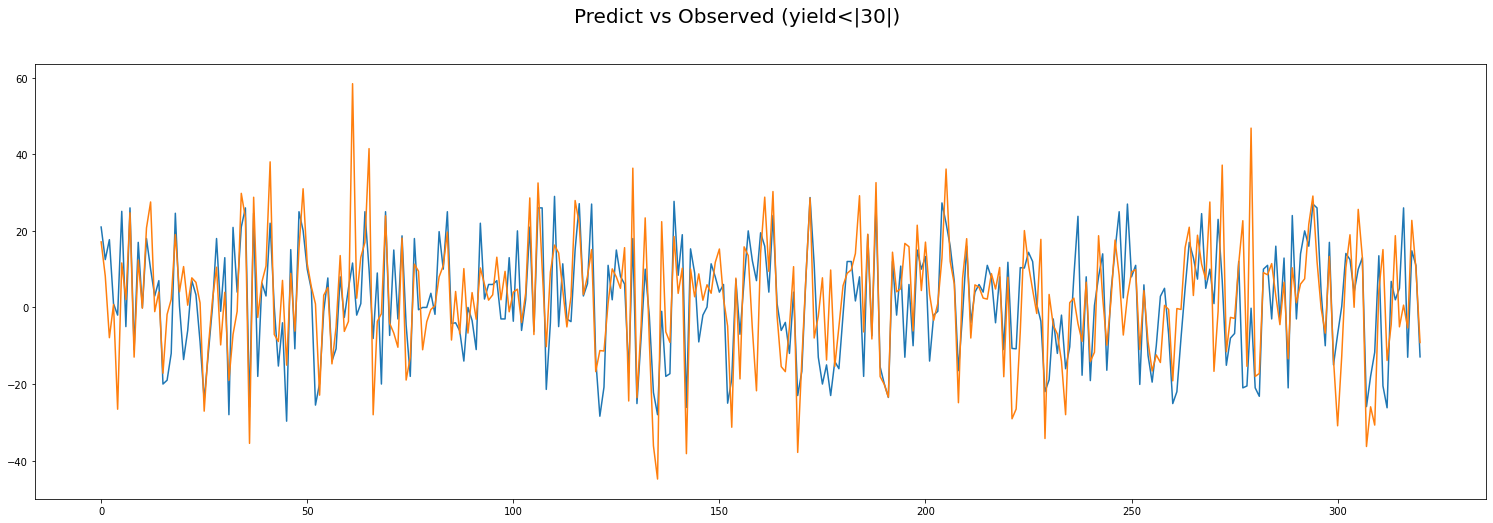

In [177]:

plt.rcParams["figure.figsize"] = (26,8)

fig = plt.figure()
plt.plot(y_testMin)
plt.plot(y_predictsMin)

fig.suptitle('Predict vs Observed (yield<|30|)', fontsize=20)

rmse (y_testMin/max(y_testMin), y_predictsMin/max(y_testMin))

0.13854492624584466

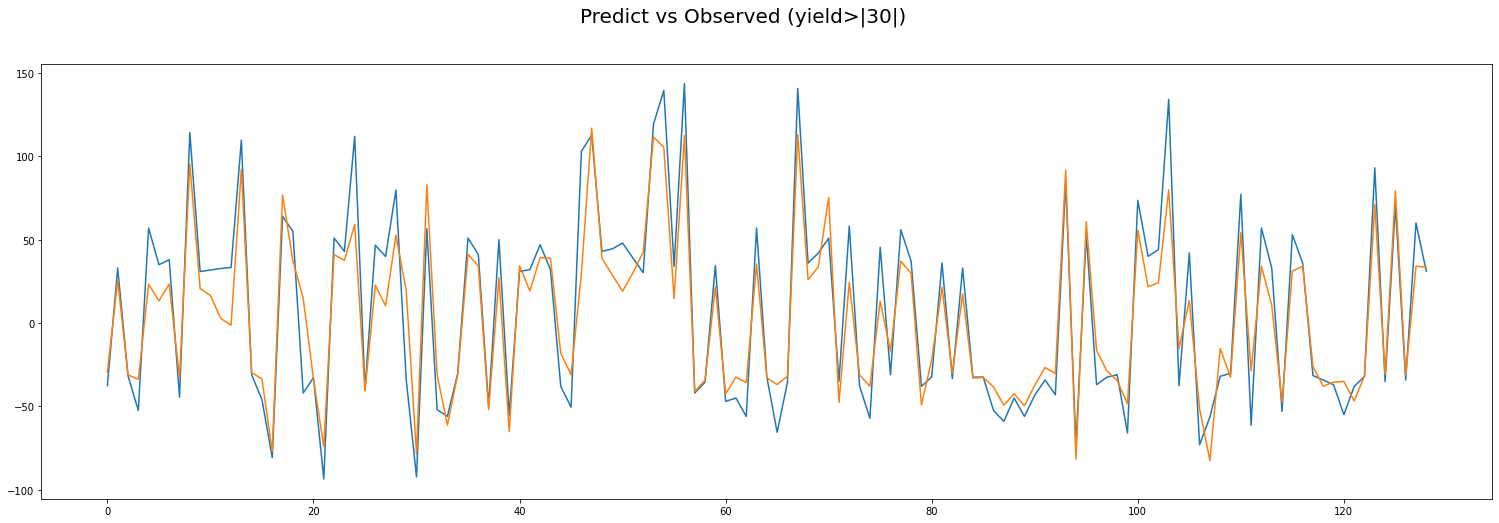

In [178]:

plt.rcParams["figure.figsize"] = (26,8)

fig = plt.figure()
plt.plot(y_testMax)
plt.plot(y_predictsMax)

fig.suptitle('Predict vs Observed (yield>|30|)', fontsize=20)

rmse (y_testMax/max(y_testMax), y_predictsMax/max(y_testMax))

In [76]:

 
def rmse (actual, pred):
    actual, pred = np.array (actual), np.array (pred)
    return np.sqrt (np.square (np.subtract (actual, pred)). mean ())

rmse (y_predicts, y_test.values)

14.572579135916092

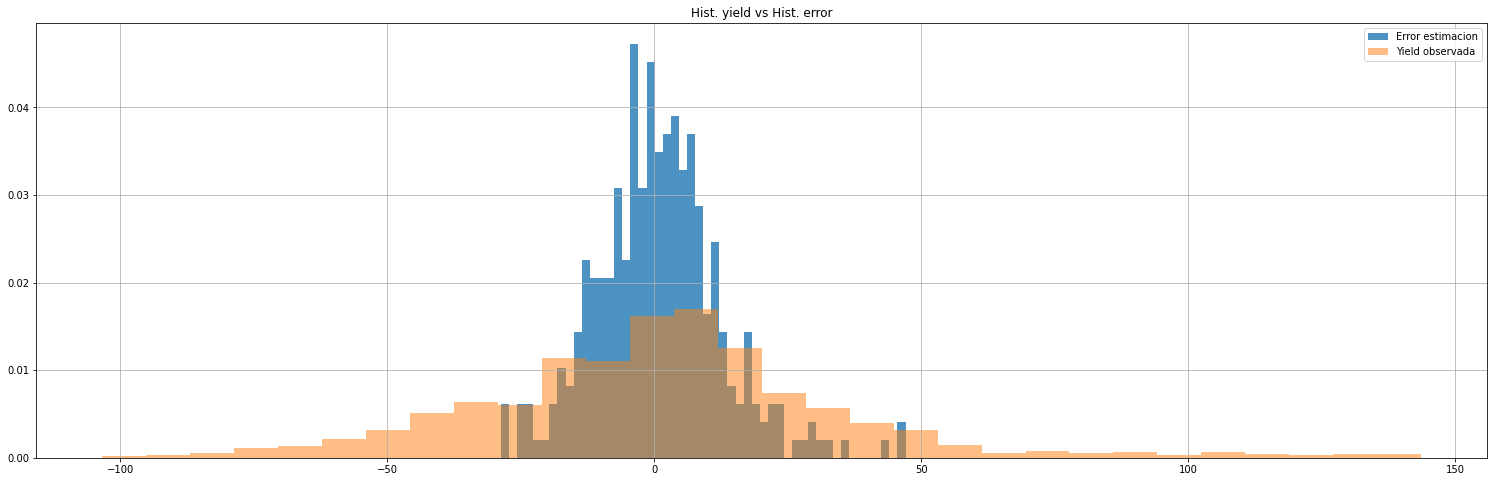

<Figure size 1872x576 with 0 Axes>

In [179]:
from random import random
import matplotlib.pyplot as plt

plt.title('Hist. yield vs Hist. error')

plt.hist(np.asarray(y_predictsMin)-np.asarray(y_testMin), 50, alpha=0.8, label='Error estimacion',density=True)
plt.hist(y, 30, alpha=0.5, label='Yield observada',density=True)
plt.legend(loc='upper right')

plt.grid(True)
plt.show()
plt.clf()